In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.cluster import KMeans
import tensorflow as tf

In [ ]:
# Load data
data_df = pd.read_csv('/content/personal_project_2024_db.csv')

Using scikit learn TfidfVectorizer vectorize the ingredients columns:

In [ ]:
vectorizer = TfidfVectorizer()
vectorized_ingredients = vectorizer.fit_transform(data_df["ingredients_list"])

Cluster the vectorized features using scikit learn KMeans cluster the cosmetic products:

In [ ]:
K = 5
kmeans = KMeans(n_clusters=K,random_state=790,n_init='auto').fit(vectorized_ingredients)

 Visualize the cluster centers using WordCloud:

In [ ]:
word_index_map = vectorizer.vocabulary_

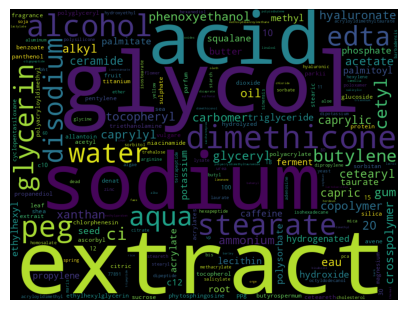

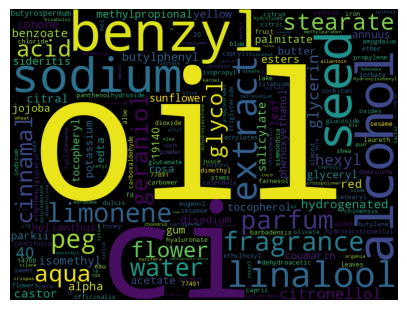

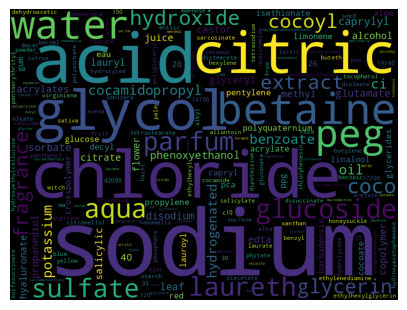

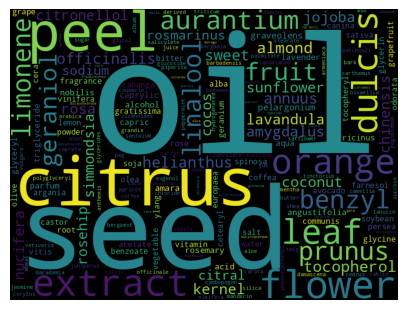

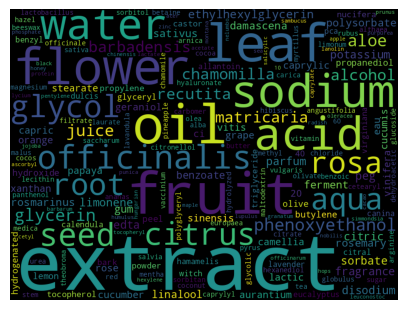

In [ ]:
for k in range(K):
  word_counts = {}
  for word in word_index_map :
    index=word_index_map[word]
    word_counts[word]=kmeans.cluster_centers_[k,index]
  wordcloud = WordCloud(width=800,height=600,relative_scaling=0.5).generate_from_frequencies(word_counts)
  plt.figure(figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

Embed the vectorized ingredients using an Keras Auto-encoder constituted by five hidden layers with embedding layer dimesion being 2:

In [ ]:
def create_autoencoder(input_dim,embedding_dim) :
  #Inputs
  inputs=tf.keras.Input(shape=(input_dim,))
  #Encoder
  encoded1=tf.keras.layers.Dense(150, activation='relu')(inputs)
  encoded2=tf.keras.layers.Dense(50, activation='relu')(encoded1)
  #embedding
  encoded=tf.keras.layers.Dense(embedding_dim,activation='linear')(encoded2)
  #Decoder
  decoded2=tf.keras.layers.Dense(50, activation='relu')(encoded)
  decoded1=tf.keras.layers.Dense(150, activation='relu')(decoded2)
  #output
  decoded=tf.keras.layers.Dense(input_dim)(decoded1)
  #Build Model
  autoencoder=tf.keras.Model(inputs, decoded)
  encoder=tf.keras.Model(inputs,encoded)
  return autoencoder, encoder

In [ ]:
input_dim=vectorized_ingredients.shape[1]
embedding_dim=2
autoencoder,encoder=create_autoencoder(input_dim,embedding_dim)
autoencoder.compile(optimizer='adam',loss='mean_squared_error')
samples=vectorized_ingredients.toarray()
training=autoencoder.fit(samples,samples,epochs=10,batch_size=32,shuffle=True)

Epoch 1/10
31/31 [==============================] - 2s 21ms/step - loss: 3.2847e-04
Epoch 2/10
31/31 [==============================] - 1s 21ms/step - loss: 3.1660e-04
Epoch 3/10
31/31 [==============================] - 1s 20ms/step - loss: 3.1530e-04
Epoch 4/10
31/31 [==============================] - 0s 14ms/step - loss: 3.1520e-04
Epoch 5/10
31/31 [==============================] - 0s 13ms/step - loss: 3.1511e-04
Epoch 6/10
31/31 [==============================] - 0s 13ms/step - loss: 3.1476e-04
Epoch 7/10
31/31 [==============================] - 0s 14ms/step - loss: 3.1376e-04
Epoch 8/10
31/31 [==============================] - 0s 13ms/step - loss: 3.1098e-04
Epoch 9/10
31/31 [==============================] - 0s 13ms/step - loss: 3.0669e-04
Epoch 10/10
31/31 [==============================] - 0s 14ms/step - loss: 3.0409e-04


In [ ]:
# Encode the ingredients
x2d=encoder.predict(samples)

31/31 [==============================] - 0s 3ms/step


Visualize the embedded ingredients of 2 dimensional. Plot the embed product and annotated as its product type

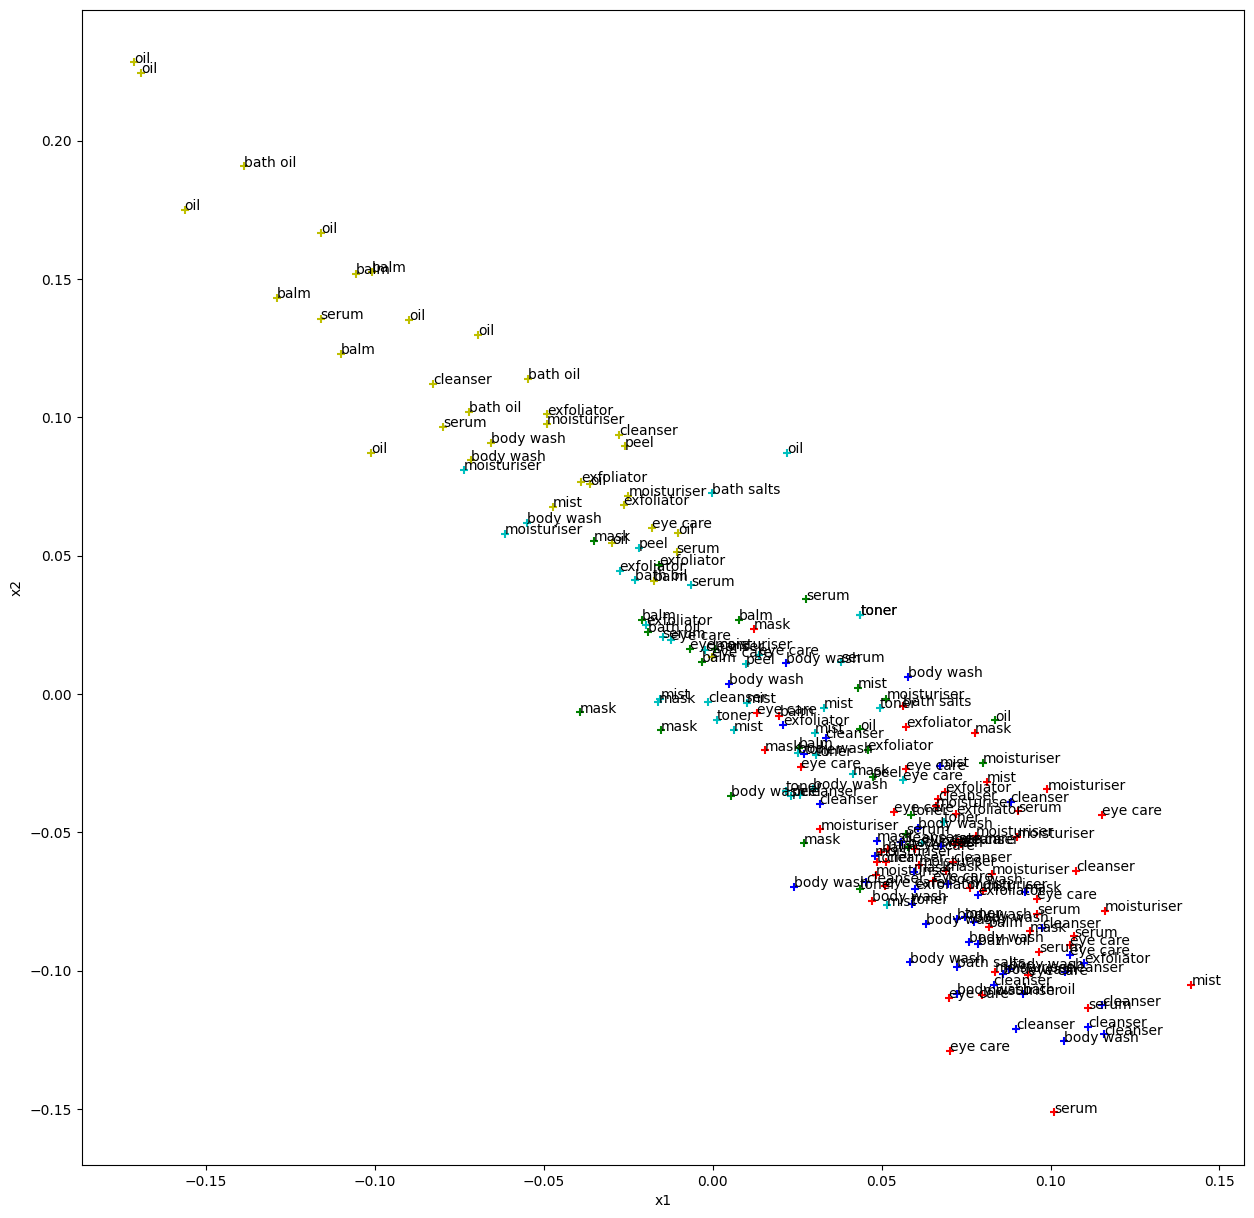

In [ ]:
product_type = [i.lower() for i in data_df["product_type"]]

color=np.array(['r','g','b','y','c','m','k','r','b','y'])
points_color=color[kmeans.labels_]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot()
for n in range(0,x2d.shape[0],5):
  ax.scatter(x2d[n,0],x2d[n,1],c=points_color[n],marker='+')
  ax.annotate(str(product_type[n]),(x2d[n,0],x2d[n,1]))
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Build a 3 hidden layer model to predict product type using vectorized ingredient with hidden layer size being selected by 3 fold cross-validation:

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

X_train, X_val, y_train, y_val = train_test_split(vectorized_ingredients, data_df['product_type'], test_size=0.2, random_state=16)

# Cross-validation for selecting optimal hidden layer size
hidden_layer_sizes = [(50,50,50), (100,100,100), (150,150,150)]
best_score = 0
best_hidden_size = None
for hidden_size in hidden_layer_sizes:
    clf = MLPClassifier(hidden_layer_sizes=hidden_size, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=3).mean()
    if score > best_score:
        best_score = score
        best_hidden_size = hidden_size
print("The best hidden layer size: ", best_hidden_size)

# Train the model with the best hidden layer size
model = MLPClassifier(hidden_layer_sizes=best_hidden_size, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))


The best hidden layer size:  (150, 150, 150)
              precision    recall  f1-score   support

        Balm       0.64      0.50      0.56        14
    Bath Oil       1.00      0.67      0.80         6
  Bath Salts       0.83      1.00      0.91         5
   Body Wash       0.75      0.96      0.84        25
    Cleanser       0.46      0.67      0.55        18
  Exfoliator       0.25      0.25      0.25         8
    Eye Care       0.56      0.29      0.38        17
        Mask       0.57      0.42      0.48        19
        Mist       0.56      0.39      0.46        23
 Moisturiser       0.36      0.67      0.47        12
         Oil       0.58      0.58      0.58        12
        Peel       0.50      0.25      0.33         4
       Serum       0.43      0.43      0.43        21
       Toner       0.50      0.54      0.52        13

    accuracy                           0.55       197
   macro avg       0.57      0.54      0.54       197
weighted avg       0.56      0.55  

A method to infer the impact of ingredients tokens on product types predictions: Using feature importance of Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier()
model_forest.fit(X_train, y_train)
y_pred = model_forest.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

        Balm       0.60      0.43      0.50        14
    Bath Oil       1.00      0.33      0.50         6
  Bath Salts       0.83      1.00      0.91         5
   Body Wash       0.69      1.00      0.82        25
    Cleanser       0.55      0.61      0.58        18
  Exfoliator       1.00      0.12      0.22         8
    Eye Care       0.62      0.59      0.61        17
        Mask       0.77      0.53      0.62        19
        Mist       0.69      0.48      0.56        23
 Moisturiser       0.36      0.67      0.47        12
         Oil       0.62      0.83      0.71        12
        Peel       0.50      0.50      0.50         4
       Serum       0.65      0.62      0.63        21
       Toner       0.53      0.62      0.57        13

    accuracy                           0.62       197
   macro avg       0.67      0.59      0.59       197
weighted avg       0.66      0.62      0.61       197



In [ ]:
feature_importance = model_forest.feature_importances_

Visualize the token impact using WordCloud

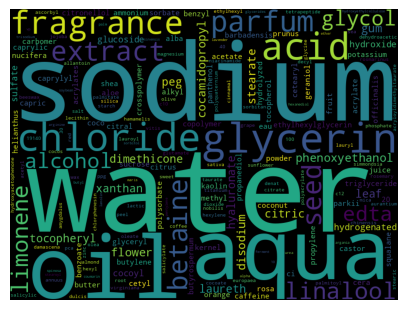

In [ ]:
word_counts = {}
for word in word_index_map :
  index=word_index_map[word]
  word_counts[word]=feature_importance[index]
wordcloud = WordCloud(width=800,height=600,relative_scaling=0.5).generate_from_frequencies(word_counts)
plt.figure(figsize=(5,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Build a Keras 3 hidden layer model to predict product prices using vectorized ingredients and product volume

In [ ]:
def create_regressor(input_dim) :

  inputs=tf.keras.Input(shape=(input_dim,))

  x=tf.keras.layers.Dense(128, activation='relu')(inputs)
  x=tf.keras.layers.Dense(64, activation='relu')(x)
  x=tf.keras.layers.Dense(32, activation='relu')(x)
  y=tf.keras.layers.Dense(1)(x)
  #Build Model
  model=tf.keras.Model(inputs,y)
  return model

In [ ]:
# Combine the vectorized ingredients zith volume feature
vectorized_ingredients_volume = np.concatenate((vectorized_ingredients.toarray(), np.expand_dims(data_df['volume'], axis=1)), axis=1)
X_train, X_val, y_train, y_val = train_test_split(vectorized_ingredients_volume, data_df['price'], test_size=0.2, random_state=42)

In [ ]:
input_dim = vectorized_ingredients.shape[1] + 1   # Combined with volume feature
neural_net=create_regressor(input_dim)
neural_net.compile(optimizer='adam',loss='mean_squared_error')
training=neural_net.fit(X_train,y_train,epochs=50,batch_size=32,shuffle=True, validation_data= (X_val, y_val))

Epoch 1/50
25/25 [==============================] - 2s 26ms/step - loss: 997.4327 - val_loss: 1034.5288
Epoch 2/50
25/25 [==============================] - 0s 16ms/step - loss: 924.6381 - val_loss: 1019.1914
Epoch 3/50
25/25 [==============================] - 0s 18ms/step - loss: 917.8022 - val_loss: 921.6203
Epoch 4/50
25/25 [==============================] - 0s 16ms/step - loss: 872.2241 - val_loss: 910.6813
Epoch 5/50
25/25 [==============================] - 0s 15ms/step - loss: 739.0833 - val_loss: 690.8522
Epoch 6/50
25/25 [==============================] - 0s 16ms/step - loss: 563.4358 - val_loss: 561.1305
Epoch 7/50
25/25 [==============================] - 1s 22ms/step - loss: 547.9272 - val_loss: 777.6631
Epoch 8/50
25/25 [==============================] - 1s 24ms/step - loss: 494.8344 - val_loss: 451.3938
Epoch 9/50
25/25 [==============================] - 0s 18ms/step - loss: 410.9588 - val_loss: 454.8538
Epoch 10/50
25/25 [==============================] - 1s 21ms/step - los

A method to infer the impact of the
brand on prices: Calculate the average price of each brand adn the vizualize using WordCloud

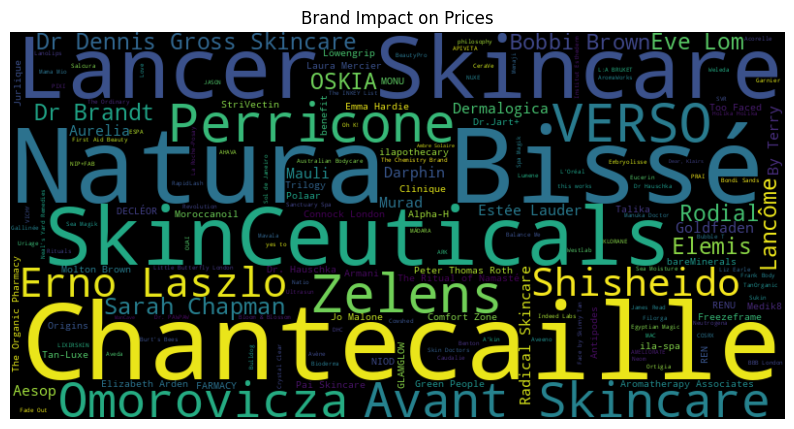

In [ ]:
brand_avg_price = data_df.groupby('brand')['price'].mean().reset_index()
brand_avg_price = brand_avg_price.set_index('brand')['price'].to_dict()

wordcloud_brands = WordCloud(width=800, height=400)
wordcloud_brands.generate_from_frequencies(brand_avg_price)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_brands, interpolation='bilinear')
plt.axis('off')
plt.title('Brand Impact on Prices')
plt.show()

A method to infer the impact of ingredient token on predicted prices: Using feature importance of Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(vectorized_ingredients, data_df['price'], test_size=0.2, random_state=42)


forest_regressor = RandomForestRegressor()
forest_regressor.fit(X_train, y_train)

y_pred = forest_regressor.predict(X_val)
print("MSE of validation set: ", mean_squared_error(y_pred, y_val))

MSE of validation set:  334.639523263597


Visualize the token impact on price using WordCloud

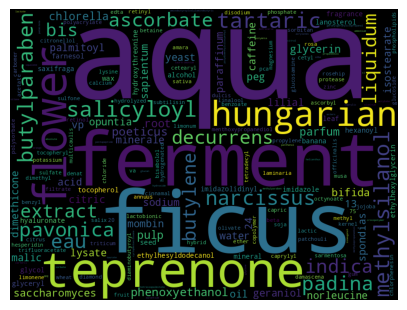

In [ ]:
feature_importance = forest_regressor.feature_importances_
word_counts = {}
for word in word_index_map :
  index=word_index_map[word]
  word_counts[word]=feature_importance[index]
wordcloud = WordCloud(width=800,height=600,relative_scaling=0.5).generate_from_frequencies(word_counts)
plt.figure(figsize=(5,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()